## Warning: If CUDA is available, use CPU instead of GPU
Overhead of GPU makes training this small model very slow, force keras to use the CPU instead.

Run the below cell before anything else:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Now, try running the imports

In [12]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Dot
import tensorflow.keras.backend as K

import pickle

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18160736319652826578
xla_global_id: -1
]


## Only proceed if no GPU device is shown in the above cell

In [4]:
train_df = pd.read_pickle('Speaker_Classification_data/train.df')
test_df = pd.read_pickle('Speaker_Classification_data/test.df')

In [5]:
train_df.head()

,inputA,inputB,label
0,"[0.7260222764214957, 0.08270111989790303, 0.32...","[0.6233947535238855, 0.25282582025278755, 0.57...",1
1,"[0.2413363410877638, 0.7268748330623002, 0.714...","[0.23485492649802936, 0.7065863924780426, 0.74...",1
2,"[0.3379175472352774, 0.8176940180434495, 0.631...","[0.2751817184968418, 0.623501179544359, 0.8096...",0
3,"[0.0, 0.2965918038868946, 0.640617865497091, 0...","[0.39686847134193626, 0.4035712918910762, 0.48...",1
4,"[0.5987898208925424, 0.35097636370378316, 0.49...","[0.6964252221305334, 0.11212877368433263, 0.47...",0


In [6]:
test_df.head()

,inputA,inputB,label
0,"[0.16942824062532894, 0.5970440897956771, 0.62...","[0.30959396106583764, 0.5229323371634897, 0.53...",1
1,"[0.5230214071302683, 0.42504837847104004, 0.50...","[0.8738742542936305, 0.33463394862909324, 0.51...",0
2,"[0.08603360241904676, 0.44053107554576604, 0.6...","[0.6310875682309952, 0.45996963344992287, 0.28...",1
3,"[0.7481191642368004, 0.555513103283351, 0.4987...","[0.5299155909060538, 0.49805445078959176, 0.77...",0
4,"[0.3104164469131456, 0.3991315174609646, 0.773...","[0.4422603064260056, 0.5414612866145064, 0.607...",1


In [7]:
def build_siamese_model(inputsize, nlayers=2, nsize=64, emb_dim=100):
    inputs = Input(inputsize)
    x = Dense(nsize, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    for _ in range(nlayers-1):
        x = Dense(nsize, activation='relu')(x)
        x = Dropout(0.1)(x)
    outputs = Dense(emb_dim)(x)
    model = Model(inputs, outputs)
    
    return model

In [8]:
def build_overall_model(input_shape, nlayers=2, nsize=64, emb_dim=100):
    inputA = Input(input_shape)
    inputB = Input(input_shape)
    featureExtractor = build_siamese_model(input_shape, nlayers, nsize, emb_dim)
    featsA = featureExtractor(inputA)
    featsB = featureExtractor(inputB)

    output_cos = Dot(axes=1, normalize=True)([featsA, featsB])
    model = Model(inputs=[inputA, inputB], outputs=output_cos)
    
    return model

In [9]:
X1_train = np.asarray(list(train_df['inputA']), dtype=np.float32)
X2_train = np.asarray(list(train_df['inputB']), dtype=np.float32)

X1_test = np.asarray(list(test_df['inputA']), dtype=np.float32)
X2_test = np.asarray(list(test_df['inputB']), dtype=np.float32)

In [10]:
def plot_from_history(hist, metric='accuracy', label='Training and Test accuracy', save_path=""):
    plt.figure()
    plt.plot(range(1, 51), hist[metric], 'orange', label='Training '+metric)
    plt.plot(range(1, 51), hist["val_"+metric], 'blue', label='Test '+metric)
    plt.title(label)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    if len(save_path):
        plt.savefig(save_path)
    plt.show()

In [14]:
nlayer_params = [1, 2]
nsize_params = [16, 32, 64]
emb_dim_params = [100, 50]
batch_size_params = [16, 4, 1]
testing_history = {}

input_shape = len(train_df['inputA'][0])
for batch_size in batch_size_params:
    for emb_dim in emb_dim_params:
        for nsize in nsize_params:
            for nlayers in nlayer_params:
                print("Building model with parameters:", nlayers, nsize, emb_dim, batch_size)
                model = build_overall_model(input_shape, nlayers, nsize, emb_dim)
                model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
                start = time.time()
                print("Training...")
                temp_history = model.fit([X1_train, X2_train], train_df['label'],
                                      validation_data=([X1_test, X2_test], test_df['label']),
                                      batch_size=batch_size, epochs=25, verbose=0)
                testing_history[(nlayers, nsize, emb_dim, batch_size)] = temp_history.history
                # saving testing history
                with open('siamese_testing.pkl', 'wb') as fileobj:
                    pickle.dump(testing_history, fileobj)
                print("Completed in:", (time.time()-start), "seconds")
                print()

Building model with parameters: 1 16 100 16
Training...
Completed in: 68.7528166770935 seconds

Building model with parameters: 2 16 100 16
Training...
Completed in: 72.7354097366333 seconds

Building model with parameters: 1 32 100 16
Training...
Completed in: 72.2981288433075 seconds

Building model with parameters: 2 32 100 16
Training...
Completed in: 74.82348775863647 seconds

Building model with parameters: 1 64 100 16
Training...
Completed in: 73.4218361377716 seconds

Building model with parameters: 2 64 100 16
Training...
Completed in: 79.10618805885315 seconds

Building model with parameters: 1 16 50 16
Training...
Completed in: 68.46935248374939 seconds

Building model with parameters: 2 16 50 16
Training...
Completed in: 72.89277410507202 seconds

Building model with parameters: 1 32 50 16
Training...
Completed in: 69.92077350616455 seconds

Building model with parameters: 2 32 50 16
Training...
Completed in: 74.26368594169617 seconds

Building model with parameters: 1 64 5

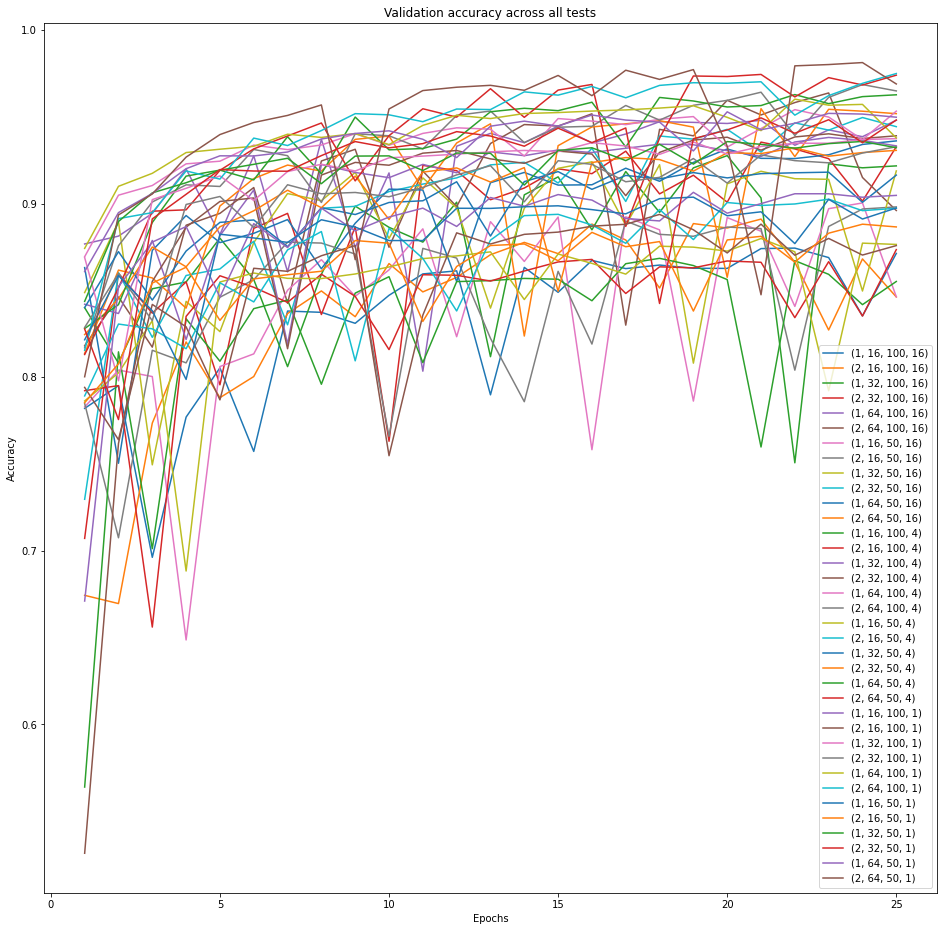

In [16]:
plt.figure(figsize=(16, 16))
for params, hist in testing_history.items():
    plt.plot(range(1, 26), hist["val_accuracy"], label=str(params))
plt.title("Validation accuracy across all tests")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

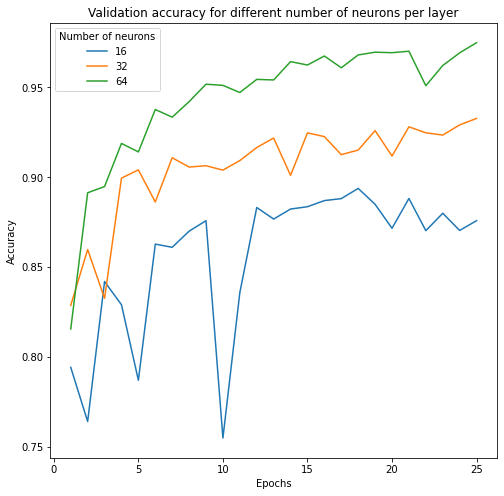

In [36]:
plt.figure(figsize=(8, 8))
for params, hist in testing_history.items():
    if params[0]==2 and params[2]==100 and params[3]==1:
        plt.plot(range(1, 26), hist["val_accuracy"], label=str(params[1]))
plt.title("Validation accuracy for different number of neurons per layer")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(title="Number of neurons")
plt.show()

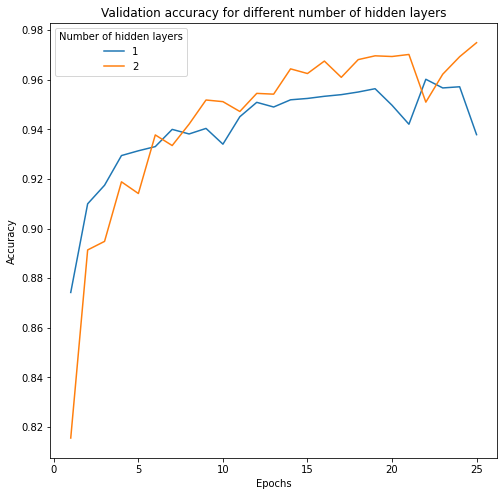

In [37]:
plt.figure(figsize=(8, 8))
for params, hist in testing_history.items():
    if params[1]==64 and params[2]==100 and params[3]==1:
        plt.plot(range(1, 26), hist["val_accuracy"], label=str(params[0]))
plt.title("Validation accuracy for different number of hidden layers")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(title="Number of hidden layers")
plt.show()

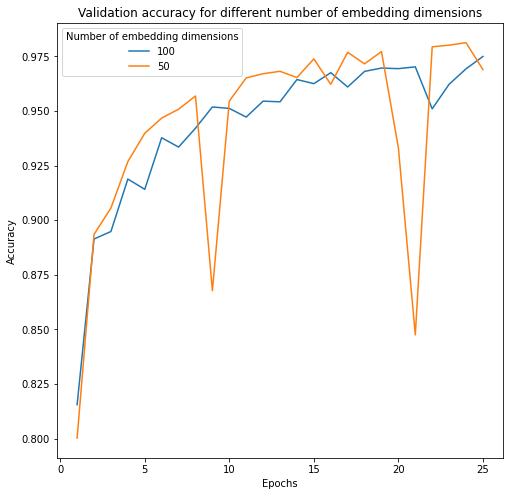

In [38]:
plt.figure(figsize=(8, 8))
for params, hist in testing_history.items():
    if params[0]==2 and params[1]==64 and params[3]==1:
        plt.plot(range(1, 26), hist["val_accuracy"], label=str(params[2]))
plt.title("Validation accuracy for different number of embedding dimensions")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(title="Number of embedding dimensions")
plt.show()

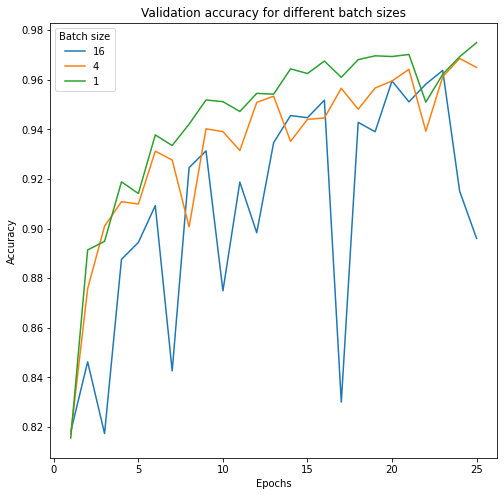

In [25]:
plt.figure(figsize=(8, 8))
for params, hist in testing_history.items():
    if params[0]==2 and params[1]==64 and params[2]==100:
        plt.plot(range(1, 26), hist["val_accuracy"], label=str(params[3]))
plt.title("Validation accuracy for different batch sizes")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(title="Batch size")
plt.show()

In [27]:
# getting final epoch values for every param combo into a df
analysis_values = []
for params, hist in testing_history.items():
    temp_row = list(params)
    temp_row.append(hist['accuracy'][-1])
    temp_row.append(hist['loss'][-1])
    temp_row.append(hist['val_accuracy'][-1])
    temp_row.append(hist['val_loss'][-1])
    analysis_values.append(temp_row)
    
analysis_df = pd.DataFrame(analysis_values, columns=['hidden_layers', 'num_neurons', 'emb_dims', 'batch_size',
                                                    'train_accuracy', 'train_loss', 'val_accuracy', 'val_loss'])
analysis_df[:]

,hidden_layers,num_neurons,emb_dims,batch_size,train_accuracy,train_loss,val_accuracy,val_loss
0,1,16,100,16,0.817709,0.418425,0.871312,0.314683
1,2,16,100,16,0.821510,0.448307,0.846241,0.376570
2,1,32,100,16,0.902625,0.252867,0.921728,0.200529
3,2,32,100,16,0.903617,0.264848,0.932792,0.198578
4,1,64,100,16,0.936927,0.180370,0.948015,0.141212
5,2,64,100,16,0.944057,0.168613,0.896030,0.270548
6,1,16,50,16,0.832877,0.440873,0.846359,0.342910
7,2,16,50,16,0.856787,0.360699,0.898109,0.284782
8,1,32,50,16,0.884969,0.291960,0.918825,0.210472
9,2,32,50,16,0.935935,0.187443,0.944327,0.156734


In [28]:
analysis_df.groupby('num_neurons', as_index=False)['val_accuracy'].mean()

,num_neurons,val_accuracy
0,16,0.877426
1,32,0.932305
2,64,0.951529


In [29]:
analysis_df.groupby('hidden_layers', as_index=False)['val_accuracy'].mean()

,hidden_layers,val_accuracy
0,1,0.916619
1,2,0.924221


In [30]:
analysis_df.groupby('emb_dims', as_index=False)['val_accuracy'].mean()

,emb_dims,val_accuracy
0,50,0.924239
1,100,0.916601


In [31]:
analysis_df.groupby('batch_size', as_index=False)['val_accuracy'].mean()

,batch_size,val_accuracy
0,1,0.928888
1,4,0.923065
2,16,0.909307


In [32]:
analysis_df.to_csv('siamese_model_parameter_tuning.csv', index=False)